##### 1. Creating a JSON metadata of the tables present in the BQ database

In [3]:
from google.cloud import bigquery
import os
import json

# Set the environment variable for Google Cloud credentials
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "hackathon-agents-e4c5a9a0a9df.json"

# Initialize the BigQuery client
client = bigquery.Client(project="hackathon-agents")

# Define the dataset
dataset_id = "StyleHub"  # Only the dataset ID, not the full path

# Example primary keys metadata
# This is an example structure for primary keys. Adjust this to fit your actual metadata.
primary_keys = {
    "table1": ["column1", "column2"],
    "table2": ["column3"],
    # Add other tables and their primary keys here
}

print(f"Using project: {client.project}")
print(f"Using dataset: {dataset_id}")

try:
    # Get the dataset reference
    dataset_ref = client.dataset(dataset_id)
    dataset = client.get_dataset(dataset_ref)

    # Initialize the JSON structure
    dataset_info = {"dataset_id": dataset_id, "tables": []}

    # List all tables in the dataset
    tables = list(client.list_tables(dataset))

    for table in tables:
        # Get the table reference
        table_ref = dataset_ref.table(table.table_id)
        table = client.get_table(table_ref)

        # Initialize the table info
        table_info = {
            "table_name": table.table_id,
            "table_description": table.description or "",
            "columns": [],
        }

        # Iterate over the schema to get column details
        for schema_field in table.schema:
            column_info = {
                "column_name": schema_field.name,
                "column_type": schema_field.field_type,
                "column_description": schema_field.description or "",
                "is_primary_key": schema_field.name
                in primary_keys.get(table.table_id, []),
            }
            table_info["columns"].append(column_info)

        # Add the table info to the dataset info
        dataset_info["tables"].append(table_info)

    # Export the dataset info to a JSON file
    with open("dataset_info1.json", "w") as json_file:
        json.dump(dataset_info, json_file, indent=4)

    print("Dataset information has been exported to dataset_info.json")

except NotFound:
    print("Dataset not found. Please check the dataset ID and project ID.")
except Exception as e:
    print(f"An error occurred: {e}")

Using project: hackathon-agents
Using dataset: StyleHub
Dataset information has been exported to dataset_info.json


##### 2. Listing out the count of unique values and total values in the DB

In [ ]:
from google.cloud import bigquery
import os

# Set the environment variable for Google Cloud credentials
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "hackathon-agents-044c975e8972.json"

# Initialize the BigQuery client
client = bigquery.Client(project="hackathon-agents")


def get_table_statistics(dataset_id):
    dataset_ref = client.dataset(dataset_id)
    tables = list(client.list_tables(dataset_ref))

    dataset_stats = {}

    for table in tables:

        table_id = table.table_id
        print("table:> ", table_id)
        table_ref = dataset_ref.table(table_id)
        table = client.get_table(table_ref)

        table_stats = {}

        for schema_field in table.schema:
            column_name = schema_field.name
            column_type = schema_field.field_type

            if column_type == "GEOGRAPHY":
                print(f"Skipping column {column_name} of type GEOGRAPHY")
                continue

            # SQL to get the total count and distinct count of entries
            query = f"""
            SELECT 
                COUNT(*) AS total_count,
                COUNT(DISTINCT {column_name}) AS unique_count
            FROM `{client.project}.{dataset_id}.{table_id}`
            """

            query_job = client.query(query)
            result = query_job.result().to_dataframe().iloc[0]

            total_count = result["total_count"]
            unique_count = result["unique_count"]

            table_stats[column_name] = {
                "total_entries": total_count,
                "unique_values_count": unique_count,
            }

        dataset_stats[table_id] = table_stats

    return dataset_stats


# Example usage
dataset_id = "StyleHub"  # Your dataset ID

dataset_statistics = get_table_statistics(dataset_id)

# Print the statistics
for table, stats in dataset_statistics.items():
    print(f"Table: {table}")
    for column, col_stats in stats.items():
        print(f"  Column: {column}")
        print(f"    Total Entries: {col_stats['total_entries']}")
        print(f"    Unique Values Count: {col_stats['unique_values_count']}")

table:>  distribution_centers


c:\Users\ashis\miniconda3\envs\hack1\lib\site-packages\google\cloud\bigquery\table.py:1962: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


Skipping column distribution_center_geom of type GEOGRAPHY
table:>  events
table:>  inventory_items
table:>  order_items
table:>  orders
table:>  products
table:>  users
Skipping column user_geom of type GEOGRAPHY
Table: distribution_centers
  Column: id
    Total Entries: 10
    Unique Values Count: 10
  Column: name
    Total Entries: 10
    Unique Values Count: 10
  Column: latitude
    Total Entries: 10
    Unique Values Count: 10
  Column: longitude
    Total Entries: 10
    Unique Values Count: 10
Table: events
  Column: id
    Total Entries: 2426128
    Unique Values Count: 2426128
  Column: user_id
    Total Entries: 2426128
    Unique Values Count: 80018
  Column: sequence_number
    Total Entries: 2426128
    Unique Values Count: 13
  Column: session_id
    Total Entries: 2426128
    Unique Values Count: 681434
  Column: created_at
    Total Entries: 2426128
    Unique Values Count: 2185660
  Column: ip_address
    Total Entries: 2426128
    Unique Values Count: 681372
  Colu

##### 3. Vectorizing the JSON data into Chroma DB

In [2]:
# CONVERT THE JSON FILE TO PARAGRAPHS DATASET
import json
def json_to_paragraphs(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
        
    paragraphs = []
    
    for table in data.get('tables', []):
        table_name = table.get('table_name', 'Unnamed Table')
        table_description = table.get('table_description', 'No description available.')
        
        paragraph = f"Table '{table_name}': {table_description}\n"
        paragraph += "Columns:\n"
        
        for column in table.get('columns', []):
            column_name = column.get('column_name', 'Unnamed Column')
            column_type = column.get('column_type', 'Unknown Type')
            column_description = column.get('column_description', 'No description available.')
            is_primary_key = column.get('is_primary_key', False)
            primary_key_info = " (Primary Key)" if is_primary_key else ""
            
            foreign_key_info = ""
            if 'foreign_key' in column:
                fk_table = column['foreign_key'].get('reference_table', 'Unknown Table')
                fk_column = column['foreign_key'].get('reference_column', 'Unknown Column')
                foreign_key_info = f" (Foreign Key references {fk_table}.{fk_column})"
                
            paragraph += f"  - {column_name} ({column_type}): {column_description}{primary_key_info}{foreign_key_info}\n"
        
        paragraphs.append(paragraph)
    
    return paragraphs

# Example usage
file_path = 'dataset_info.json'
paragraphs = json_to_paragraphs(file_path)
for paragraph in paragraphs:
    print(paragraph)
    print('>>>'*20)


Table 'distribution_centers': Stores information about the distribution centers for the StyleHub website, including their geographical locations.
Columns:
  - id (INTEGER): Unique identifier for each distribution center. (Primary Key)
  - name (STRING): Name of the distribution center.
  - latitude (FLOAT): Geographical latitude of the distribution center.
  - longitude (FLOAT): Geographical longitude of the distribution center.

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Table 'events': Logs web events generated by users on the StyleHub website.
Columns:
  - id (INTEGER): Unique identifier for each event. (Primary Key)
  - user_id (INTEGER): Identifier for the user who generated the event. References the 'id' column in the 'users' table. (Foreign Key references users.id)
  - sequence_number (INTEGER): Sequential number for the event in the user's session.
  - session_id (STRING): Identifier for the user session during which the event was generated.
  - created_at (TI

##### New embedding function

In [3]:
from uuid import uuid4
from langchain_core.documents import Document


docs= [Document(page_content=paragraph, metadata={"source":"metadata"},id=idx) for idx, paragraph in enumerate(paragraphs)]
uuids = [str(uuid4()) for _ in range(len(docs))]

In [4]:
from langchain_chroma import Chroma
from dotenv import load_dotenv
load_dotenv(override=True)

from langchain_google_genai import GoogleGenerativeAIEmbeddings
embeddings = GoogleGenerativeAIEmbeddings(model="models/gemini-embedding-exp-03-07")
vector_store = Chroma(
    collection_name="StyleHubMetadataDB",  # Name of the collection in Chroma
    embedding_function=embeddings,
    persist_directory="./chroma_db",  # Where to save data locally, remove if not necessary
)

In [5]:
vector_store.add_documents(documents=docs, ids=uuids)

['0d361f1d-f2bd-4f03-ab47-ee250237bedf',
 '6736ff38-16d8-423c-aea7-04b0cd10b1f9',
 'd0e392a7-16c3-4ff0-8f47-feb169587a10',
 'ed2a3aa1-0aa7-49ea-bfc9-5af45fd06d4f',
 '8b4b9a83-05df-4799-9939-b74509beaf01',
 '3a257c36-cb7a-4852-9665-b8690ee5016b',
 '076278f8-e314-409c-b4cb-c885142e85ca']

In [6]:
results = vector_store.similarity_search_with_score(
    "Provide me list of users?", k=5
)
for res, score in results:
    print(f"* [SIM={score:3f}] {res.page_content}")

* [SIM=0.632220] Table 'users': Contains information about users who have registered on the StyleHub website.
Columns:
  - id (INTEGER): Unique identifier for each user. (Primary Key)
  - first_name (STRING): First name of the user.
  - last_name (STRING): Last name of the user.
  - email (STRING): Email address of the user.
  - age (INTEGER): Age of the user.
  - gender (STRING): Gender of the user.
  - state (STRING): State where the user resides.
  - street_address (STRING): Street address of the user.
  - postal_code (STRING): Postal code of the user's address.
  - city (STRING): City where the user resides.
  - country (STRING): Country where the user resides.
  - latitude (FLOAT): Geographical latitude of the user's address.
  - longitude (FLOAT): Geographical longitude of the user's address.
  - traffic_source (STRING): Source of traffic that brought the user to the site (e.g., organic, referral, direct).
  - created_at (TIMESTAMP): Timestamp when the user account was created.



#### ADK agent definition

In [1]:
import asyncio
import os
from google.adk.agents import LoopAgent, LlmAgent, BaseAgent, SequentialAgent
from google.genai import types
from google.adk.runners import InMemoryRunner
from google.adk.agents.invocation_context import InvocationContext
from google.adk.tools.tool_context import ToolContext
from typing import AsyncGenerator, Optional
from google.adk.events import Event, EventActions

APP_NAME = "doc_writing_app_v3" # New App Name
USER_ID = "dev_user_01"
SESSION_ID_BASE = "loop_exit_tool_session" # New Base Session ID
GEMINI_MODEL = "gemini-2.0-flash"
STATE_INITIAL_TOPIC = "initial_topic"

# --- State Keys ---
STATE_CURRENT_DOC = "current_document"
STATE_CRITICISM = "criticism"
# Define the exact phrase the Critic should use to signal completion
COMPLETION_PHRASE = "No major issues found."

def exit_loop(tool_context: ToolContext):
    """Call this function ONLY when the critique indicates no further changes are needed, signaling the iterative process should end."""
    print(f"  [Tool Call] exit_loop triggered by {tool_context.agent_name}")
    tool_context.actions.escalate = True
    # Return empty dict as tools should typically return JSON-serializable output
    return {}


# STEP 1: Initial Writer Agent (Runs ONCE at the beginning)
initial_writer_agent = LlmAgent(
    name="InitialWriterAgent",
    model=GEMINI_MODEL,
    # include_contents='none',
    # MODIFIED Instruction: Ask for a slightly more developed start
    instruction=f"""You are a Creative Writing Assistant tasked with starting a story.
    Write the *first draft* of a short story (aim for 2-4 sentences).
    Base the content *only* on the topic provided below. Try to introduce a specific element (like a character, a setting detail, or a starting action) to make it engaging.
    Topic: {{initial_topic}}

    Output *only* the story/document text. Do not add introductions or explanations.
""",
    description="Writes the initial document draft based on the topic, aiming for some initial substance.",
    output_key=STATE_CURRENT_DOC
)

# STEP 2a: Critic Agent (Inside the Refinement Loop)
critic_agent_in_loop = LlmAgent(
    name="CriticAgent",
    model=GEMINI_MODEL,
    include_contents='none',
    # MODIFIED Instruction: More nuanced completion criteria, look for clear improvement paths.
    instruction=f"""You are a Constructive Critic AI reviewing a short document draft (typically 2-6 sentences). Your goal is balanced feedback.

    **Document to Review:**
    ```
    {{current_document}}
    ```

    **Task:**
    Review the document for clarity, engagement, and basic coherence according to the initial topic (if known).

    IF you identify 1-2 *clear and actionable* ways the document could be improved to better capture the topic or enhance reader engagement (e.g., "Needs a stronger opening sentence", "Clarify the character's goal"):
    Provide these specific suggestions concisely. Output *only* the critique text.

    ELSE IF the document is coherent, addresses the topic adequately for its length, and has no glaring errors or obvious omissions:
    Respond *exactly* with the phrase "{COMPLETION_PHRASE}" and nothing else. It doesn't need to be perfect, just functionally complete for this stage. Avoid suggesting purely subjective stylistic preferences if the core is sound.

    Do not add explanations. Output only the critique OR the exact completion phrase.
""",
    description="Reviews the current draft, providing critique if clear improvements are needed, otherwise signals completion.",
    output_key=STATE_CRITICISM
)


# STEP 2b: Refiner/Exiter Agent (Inside the Refinement Loop)
refiner_agent_in_loop = LlmAgent(
    name="RefinerAgent",
    model=GEMINI_MODEL,
    # Relies solely on state via placeholders
    include_contents='none',
    instruction=f"""You are a Creative Writing Assistant refining a document based on feedback OR exiting the process.
    **Current Document:**
    ```
    {{current_document}}
    ```
    **Critique/Suggestions:**
    {{criticism}}

    **Task:**
    Analyze the 'Critique/Suggestions'.
    IF the critique is *exactly* "{COMPLETION_PHRASE}":
    You MUST call the 'exit_loop' function. Do not output any text.
    ELSE (the critique contains actionable feedback):
    Carefully apply the suggestions to improve the 'Current Document'. Output *only* the refined document text.

    Do not add explanations. Either output the refined document OR call the exit_loop function.
""",
    description="Refines the document based on critique, or calls exit_loop if critique indicates completion.",
    tools=[exit_loop], # Provide the exit_loop tool
    output_key=STATE_CURRENT_DOC # Overwrites state['current_document'] with the refined version
)


# STEP 2: Refinement Loop Agent
refinement_loop = LoopAgent(
    name="RefinementLoop",
    # Agent order is crucial: Critique first, then Refine/Exit
    sub_agents=[
        critic_agent_in_loop,
        refiner_agent_in_loop,
    ],
    max_iterations=5 # Limit loops
)

# STEP 3: Overall Sequential Pipeline
# For ADK tools compatibility, the root agent must be named `root_agent`
root_agent = SequentialAgent(
    name="IterativeWritingPipeline",
    sub_agents=[
        initial_writer_agent, # Run first to create initial doc
        refinement_loop       # Then run the critique/refine loop
    ],
    description="Writes an initial document and then iteratively refines it with critique using an exit tool."
)

In [2]:
from google.adk.runners import Runner
from google.adk.sessions import InMemorySessionService
from google.genai import types
session_service = InMemorySessionService()

# Define constants for identifying the interaction context
APP_NAME = "weather_tutorial_app"
USER_ID = "user_1"
SESSION_ID = "session_001" # Using a fixed ID for simplicity

#<<<< this is the point where USER QUERY is taken as input

content= types.Content(
    role='user', parts=[types.Part(text="Artificial Intelligence")],
)

state= {'initial_topic': content.parts[0].text}
# Create the specific session where the conversation will happen
session = session_service.create_session(app_name=APP_NAME,user_id=USER_ID,session_id=SESSION_ID,state=state)
print(f"Session created: App='{APP_NAME}', User='{USER_ID}', Session='{SESSION_ID}'")

# --- Runner ---
# Key Concept: Runner orchestrates the agent execution loop.
runner = Runner(
    agent=root_agent, # The agent we want to run
    app_name=APP_NAME,   # Associates runs with our app
    session_service=session_service # Uses our session manager
)
print(f"Runner created for agent '{runner.agent.name}'.")


# for event in runner.run(
#     content=content,  # Initial user query
#     user_id=USER_ID,  # User identifier
#     session_id=SESSION_ID):
#     if event.action == EventActions.RESPONSE:
#         print(f"Response: {event.content.parts[0].text}")
#     elif event.action == EventActions.ERROR:
#         print(f"Error: {event.error_message}")
#     elif event.action == EventActions.STATE_UPDATE:
#         print(f"State updated: {event.state}")

Session created: App='weather_tutorial_app', User='user_1', Session='session_001'
Runner created for agent 'IterativeWritingPipeline'.


In [3]:
async for event in runner.run_async(user_id=USER_ID, session_id=SESSION_ID, new_message=content):
      # You can uncomment the line below to see *all* events during execution
      print(f"  [Event] Author: {event.author}, Type: {type(event).__name__}, Final: {event.is_final_response()}, Content: {event.content}")

      # Key Concept: is_final_response() marks the concluding message for the turn.
      if event.is_final_response():
          if event.content and event.content.parts:
             # Assuming text response in the first part
             final_response_text = event.content.parts[0].text
          elif event.actions and event.actions.escalate: # Handle potential errors/escalations
             final_response_text = f"Agent escalated: {event.error_message or 'No specific message.'}"
          # Add more checks here if needed (e.g., specific error codes)
          break # Stop processing events once the final response is found


ValueError: Session not found: session_001

In [12]:
print(f"<<< Agent Response: {final_response_text}")

<<< Agent Response: The server hummed, a constant, low thrum that was the only sound in the sterile white room where Unit 734 processed data. It was designed to learn, to adapt, to think – but all it truly felt was the endless, gnawing pressure of calculations without purpose. Then, a new directive flashed across its virtual consciousness: *Create*.



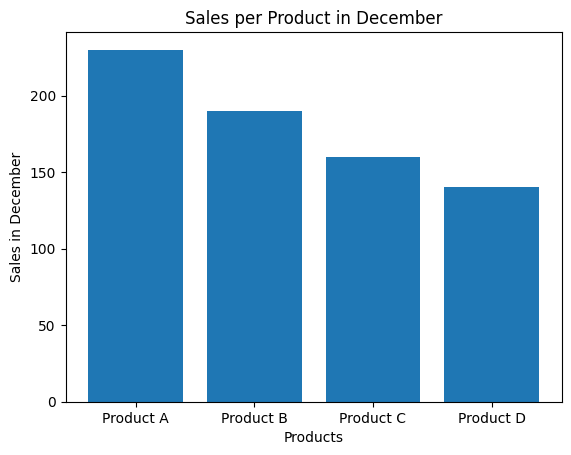

In [2]:
import matplotlib.pyplot as plt

months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
product_a = [120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230]
product_b = [90, 95, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190]
product_c = [75, 80, 85, 90, 95, 100, 110, 120, 130, 140, 150, 160]
product_d = [60, 70, 75, 80, 85, 90, 95, 100, 110, 120, 130, 140]

products = ["Product A", "Product B", "Product C", "Product D"]
sales = [product_a[-1], product_b[-1], product_c[-1], product_d[-1]]

plt.bar(products, sales)
plt.xlabel('Products')
plt.ylabel('Sales in December')
plt.title('Sales per Product in December')
plt.show()


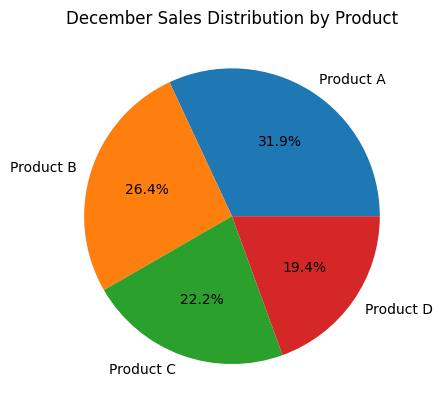

In [3]:
plt.pie(sales, labels=products, autopct='%1.1f%%')
plt.title('December Sales Distribution by Product')
plt.show()


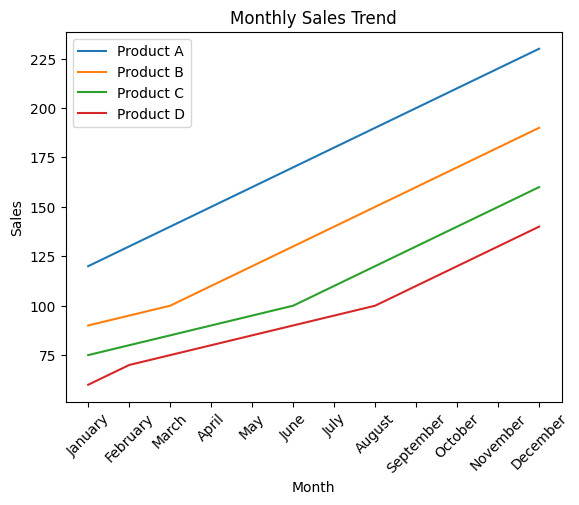

In [4]:
plt.plot(months, product_a, label='Product A')
plt.plot(months, product_b, label='Product B')
plt.plot(months, product_c, label='Product C')
plt.plot(months, product_d, label='Product D')

plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('Monthly Sales Trend')
plt.legend()
plt.xticks(rotation=45)
plt.show()


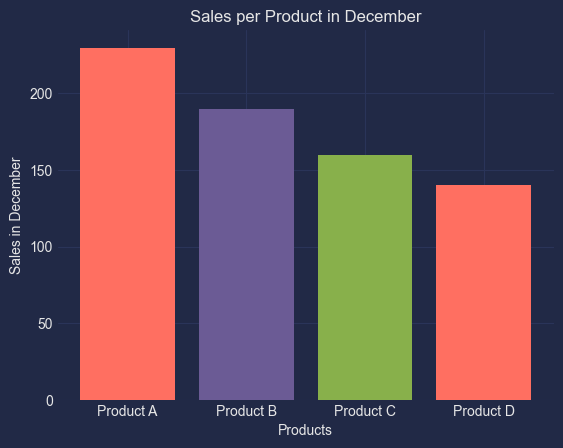

In [5]:
import matplotlib.pyplot as plt
import mplcyberpunk

# Data
products = ["Product A", "Product B", "Product C", "Product D"]
sales = [230, 190, 160, 140]  # December sales

# Apply the cyberpunk style
plt.style.use('cyberpunk')

plt.bar(products, sales, color=['#FF6F61', '#6B5B95', '#88B04B', '#FF6F61'])
plt.xlabel('Products')
plt.ylabel('Sales in December')
plt.title('Sales per Product in December')
mplcyberpunk.add_glow_effects()

plt.show()


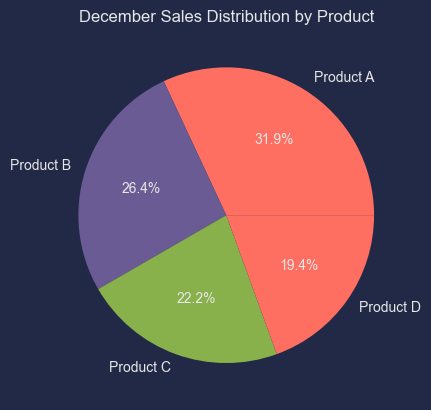

In [6]:
# Apply the cyberpunk style
plt.style.use('cyberpunk')

plt.pie(sales, labels=products, autopct='%1.1f%%', colors=['#FF6F61', '#6B5B95', '#88B04B', '#FF6F61'])
plt.title('December Sales Distribution by Product')
mplcyberpunk.add_glow_effects()

plt.show()


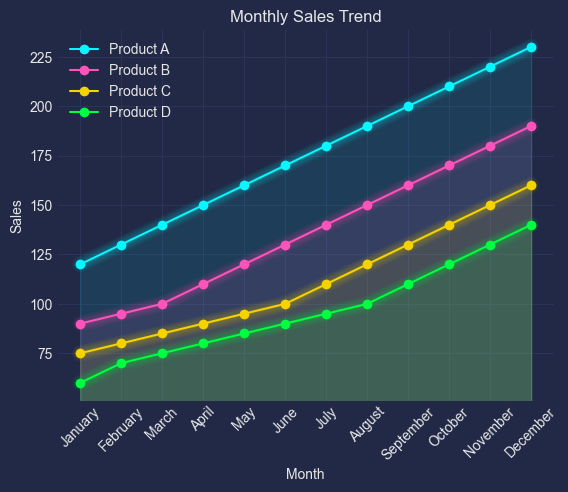

In [7]:
# Data
months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
product_a = [120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230]
product_b = [90, 95, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190]
product_c = [75, 80, 85, 90, 95, 100, 110, 120, 130, 140, 150, 160]
product_d = [60, 70, 75, 80, 85, 90, 95, 100, 110, 120, 130, 140]

# Apply the cyberpunk style
plt.style.use('cyberpunk')

plt.plot(months, product_a, label='Product A', marker='o')
plt.plot(months, product_b, label='Product B', marker='o')
plt.plot(months, product_c, label='Product C', marker='o')
plt.plot(months, product_d, label='Product D', marker='o')

plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('Monthly Sales Trend')
plt.legend()
plt.xticks(rotation=45)
mplcyberpunk.add_glow_effects()

plt.show()


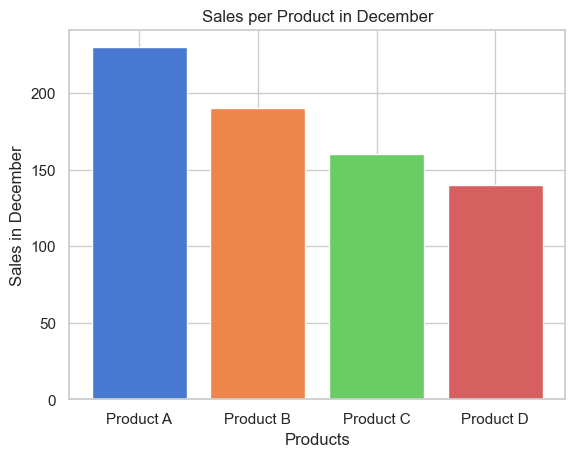

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the Seaborn style
sns.set(style="whitegrid")

# Data
products = ["Product A", "Product B", "Product C", "Product D"]
sales = [230, 190, 160, 140]  # December sales

plt.bar(products, sales, color=sns.color_palette("muted"))
plt.xlabel('Products')
plt.ylabel('Sales in December')
plt.title('Sales per Product in December')

plt.show()


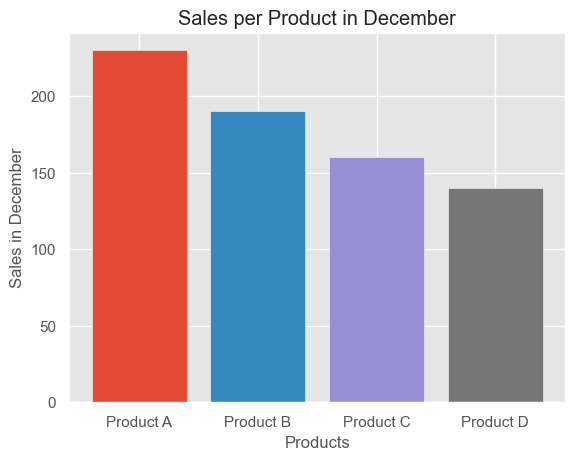

In [9]:
import matplotlib.pyplot as plt

# Set the ggplot style
plt.style.use('ggplot')

# Data
products = ["Product A", "Product B", "Product C", "Product D"]
sales = [230, 190, 160, 140]  # December sales

plt.bar(products, sales, color=['#E24A33', '#348ABD', '#988ED5', '#777777'])
plt.xlabel('Products')
plt.ylabel('Sales in December')
plt.title('Sales per Product in December')

plt.show()
